In [462]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import mysql.connector
import numpy as np
import math
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import mixture
%matplotlib inline

In [463]:
############ CONNECT TO THE DATABASE - OSX/Windows ############
# connection = pymysql.connect(host='localhost',
#                              user='root',
#                              password='root',#put your password for mysql server here.
#                              db='yelp_db',
#                              charset='utf8mb4',
#                              cursorclass=pymysql.cursors.DictCursor)

############ CONNECT TO THE DATABASE - RHEL ############
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    port=3306,
    database='yelp_db')

data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.city,
  business.neighborhood,
  category.category
  FROM category
  inner join business on
  business.id = category.business_id
  WHERE business.city ="Pittsburgh"
  and neighborhood IS NOT NULL
  and category.category = "Italian"
  or category.category = "Chinese"
  or category.category = "Mexican"
  or category.category = "American (New)"
  or category.category = "Korean"
  or category.category = "Japanese"
  or category.category = "Thai"
  or category.category = "Indian"
  or category.category = "Mediterranean"
  or category.category = "Greek"
  or category.category = "French"
  or category.category = "Turkish"
  or category.category = "Caribbean"
  or category.category = "Vietnamese"
  or category.category = "Latin American"
  or category.category = "Taiwanese"
  or category.category = "Tex-Mex"
  or category.category = "Barbeque"
  or category.category = "Cafes"
  or category.category = "Sandwiches"
  GROUP BY business.id, category.category''',connection) #.values


# or category.category = "Mediterranean"
#   or category.category = "Greek"
#   or category.category = "French"
# or category.category = "Turkish"
#   or category.category = "Caribbean"
#   or category.category = "Vietnamese"
#   or category.category = "Latin American"
#   or category.category = "Taiwanese"

In [464]:
#### CLUSTERING BY NEIGHBORHOOD
dfh = data[['latitude','longitude','city','neighborhood','category']]
dfh = dfh.loc[dfh['city'] == 'Pittsburgh']
dfh = dfh[['latitude','longitude','neighborhood','category']]

neighborhoods = dfh.neighborhood.unique()
#print(dfh)

In [465]:
#dfh.neighborhood.value_counts() # there are 46 neighborhoods

In [466]:
dfh.category.value_counts()

Sandwiches        301
American (New)    281
Italian           207
Chinese           128
Mexican           112
Cafes             109
Mediterranean      60
Japanese           59
Thai               53
Barbeque           47
Indian             35
Greek              31
Latin American     20
French             18
Tex-Mex            16
Turkish            15
Korean             15
Caribbean          12
Vietnamese         11
Taiwanese          10
Name: category, dtype: int64

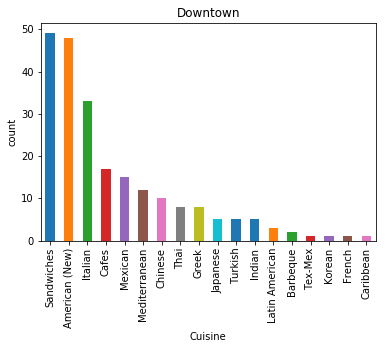

In [467]:
downtown = dfh.loc[dfh['neighborhood'] == 'Downtown']

p = downtown['category'].value_counts(sort=True).plot.bar()
p.set_title("Downtown")
p.set_xlabel("Cuisine")
p.set_ylabel("count")
plt.savefig('downtown_cuisines.pdf', bbox_inches='tight')

In [468]:
dfh['neighborhood'].replace('',0,inplace=True)
dfh['neighborhood'].replace('Downtown',1, inplace=True)
dfh['neighborhood'].replace('Oakland',2, inplace=True)
dfh['neighborhood'].replace('South Side',3, inplace=True)
dfh['neighborhood'].replace('Squirrel Hill',4, inplace=True)
dfh['neighborhood'].replace('Shadyside',5, inplace=True)
dfh['neighborhood'].replace('Lawrenceville',6, inplace=True)
dfh['neighborhood'].replace('Bloomfield',7, inplace=True)
dfh['neighborhood'].replace('Strip District',8, inplace=True)
dfh['neighborhood'].replace('North Side',9, inplace=True)
dfh['neighborhood'].replace('East Liberty',10, inplace=True)
dfh['neighborhood'].replace('Dormont',11, inplace=True)
dfh['neighborhood'].replace('Brookline',12, inplace=True)
dfh['neighborhood'].replace('Beechview',13, inplace=True)
dfh['neighborhood'].replace('Carrick',14, inplace=True)
dfh['neighborhood'].replace('Banksville',15, inplace=True)
dfh['neighborhood'].replace('Garfield',16, inplace=True)
dfh['neighborhood'].replace('West View',17, inplace=True)
dfh['neighborhood'].replace('Mt. Washington',18, inplace=True)
dfh['neighborhood'].replace('Greentree',19, inplace=True)
dfh['neighborhood'].replace('The Hill District',20, inplace=True)
dfh['neighborhood'].replace('Regent Square',21, inplace=True)
dfh['neighborhood'].replace('Aspinwall',22, inplace=True)
dfh['neighborhood'].replace('Greenfield',23, inplace=True)
dfh['neighborhood'].replace('Highland Park',24, inplace=True)
dfh['neighborhood'].replace('West End',25, inplace=True)
dfh['neighborhood'].replace('Duquesne Heights',26, inplace=True)
dfh['neighborhood'].replace('Bellevue',27, inplace=True)
dfh['neighborhood'].replace('Friendship',28, inplace=True)
dfh['neighborhood'].replace('Allentown',29, inplace=True)
dfh['neighborhood'].replace('Emsworth',30, inplace=True)
dfh['neighborhood'].replace('Point Breeze',31, inplace=True)
dfh['neighborhood'].replace('Larimer',32, inplace=True)
dfh['neighborhood'].replace('Troy Hill',33, inplace=True)
dfh['neighborhood'].replace('Sharpsburg',34, inplace=True)
dfh['neighborhood'].replace('Carnegie',35, inplace=True)
dfh['neighborhood'].replace('Avalon',36, inplace=True)
dfh['neighborhood'].replace('Etna',37, inplace=True)
dfh['neighborhood'].replace('Bon Air',38, inplace=True)
dfh['neighborhood'].replace('South Side Slopes',39, inplace=True)
dfh['neighborhood'].replace('Knoxville',40, inplace=True)
dfh['neighborhood'].replace('East Carnegie',41, inplace=True)
dfh['neighborhood'].replace('Overbrook',42, inplace=True)
dfh['neighborhood'].replace('Mt. Oliver',43, inplace=True)
dfh['neighborhood'].replace('Morningside',44, inplace=True)
dfh['neighborhood'].replace('Homestead',45, inplace=True)
dfh['neighborhood'].replace('Homewood',46, inplace=True)
dfh['neighborhood'].replace('Brighton Heights',47, inplace=True)
dfh['neighborhood'].replace('Arlington',48, inplace=True)

In [469]:
# drop all neighborhoods except download
dfh = dfh[dfh.neighborhood != 0]

dfh = dfh[dfh.neighborhood != 4]
dfh = dfh[dfh.neighborhood != 2]
dfh = dfh[dfh.neighborhood != 3]
dfh = dfh[dfh.neighborhood != 5]
dfh = dfh[dfh.neighborhood != 6]
dfh = dfh[dfh.neighborhood != 7]
dfh = dfh[dfh.neighborhood != 8]
dfh = dfh[dfh.neighborhood != 9]
dfh = dfh[dfh.neighborhood != 10]
dfh = dfh[dfh.neighborhood != 11]
dfh = dfh[dfh.neighborhood != 12]
dfh = dfh[dfh.neighborhood != 13]
dfh = dfh[dfh.neighborhood != 14]
dfh = dfh[dfh.neighborhood != 15]
dfh = dfh[dfh.neighborhood != 16]
dfh = dfh[dfh.neighborhood != 17]
dfh = dfh[dfh.neighborhood != 18]
dfh = dfh[dfh.neighborhood != 19]
dfh = dfh[dfh.neighborhood != 20]
dfh = dfh[dfh.neighborhood != 21]
dfh = dfh[dfh.neighborhood != 22]
dfh = dfh[dfh.neighborhood != 23]
dfh = dfh[dfh.neighborhood != 24]
dfh = dfh[dfh.neighborhood != 25]
dfh = dfh[dfh.neighborhood != 26]
dfh = dfh[dfh.neighborhood != 27]
dfh = dfh[dfh.neighborhood != 28]
dfh = dfh[dfh.neighborhood != 29]
dfh = dfh[dfh.neighborhood != 30]
dfh = dfh[dfh.neighborhood != 31]
dfh = dfh[dfh.neighborhood != 32]
dfh = dfh[dfh.neighborhood != 33]
dfh = dfh[dfh.neighborhood != 34]
dfh = dfh[dfh.neighborhood != 35]
dfh = dfh[dfh.neighborhood != 36]
dfh = dfh[dfh.neighborhood != 37]
dfh = dfh[dfh.neighborhood != 38]
dfh = dfh[dfh.neighborhood != 39]
dfh = dfh[dfh.neighborhood != 40]
dfh = dfh[dfh.neighborhood != 41]
dfh = dfh[dfh.neighborhood != 42]
dfh = dfh[dfh.neighborhood != 43]
dfh = dfh[dfh.neighborhood != 44]
dfh = dfh[dfh.neighborhood != 45]
dfh = dfh[dfh.neighborhood != 46]
dfh = dfh[dfh.neighborhood != 47]
dfh = dfh[dfh.neighborhood != 48]

In [470]:
dfh.neighborhood.value_counts()

1    224
Name: neighborhood, dtype: int64

In [471]:
dfh.category.value_counts()

Sandwiches        49
American (New)    48
Italian           33
Cafes             17
Mexican           15
Mediterranean     12
Chinese           10
Thai               8
Greek              8
Japanese           5
Turkish            5
Indian             5
Latin American     3
Barbeque           2
Tex-Mex            1
Korean             1
French             1
Caribbean          1
Name: category, dtype: int64

In [472]:
new_dfh = dfh[['latitude','longitude']].copy()
#new_dfh.drop('neighborhood', 1, inplace=True)
#new_dfh.drop('category', 1, inplace=True)

from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(new_dfh)
pca_2d = pca.fit_transform(new_dfh) #transform, fit
#W = pca_2d.components_
#X_proj = np.matrix(new_dfh)*W.T

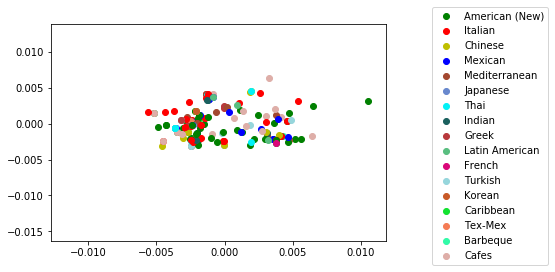

In [473]:
import pylab as pl
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

dfh['category'].replace('American (New)',0,inplace=True)
dfh['category'].replace('Italian',1, inplace=True)
dfh['category'].replace('Chinese',2, inplace=True)
dfh['category'].replace('Mexican',3, inplace=True)
dfh['category'].replace('Mediterranean',4, inplace=True)
dfh['category'].replace('Japanese',5, inplace=True)
dfh['category'].replace('Thai',6, inplace=True)
dfh['category'].replace('Indian',7, inplace=True)
dfh['category'].replace('Greek',8, inplace=True)
dfh['category'].replace('Latin American',9, inplace=True)
dfh['category'].replace('French',10, inplace=True)
dfh['category'].replace('Turkish',11, inplace=True)
dfh['category'].replace('Korean',12, inplace=True)
dfh['category'].replace('Caribbean',13, inplace=True)
dfh['category'].replace('Tex-Mex',14, inplace=True)
dfh['category'].replace('Barbeque',15, inplace=True)
dfh['category'].replace('Cafes',16, inplace=True)
dfh['category'].replace('Sandwiches',17, inplace=True)

values = dfh.category.tolist()

for i in range(0, pca_2d.shape[0]): # X_proj
    if values[i] == 0:
        c0= pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g')
    elif values[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r')
    elif values[i] == 2:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y')
    elif values[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b')
    elif values[i] == 4:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#A34830')
    elif values[i] == 5:
        c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#6888CD')
    elif values[i] == 6:
        c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#03F1F6')
    elif values[i] == 7:
        c7 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#1A605E')
    elif values[i] == 8:
        c8 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#B8393C')
    elif values[i] == 9:
        c9 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#59BE80')
    elif values[i] == 10:
        c10 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#DA0779')
    elif values[i] == 11:
        c11 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#96D6DC')
    elif values[i] == 12:
        c12 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#C85A28')
    elif values[i] == 13:
        c13 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#12E230')
    elif values[i] == 14:
        c14 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#F57C55')
    elif values[i] == 15:
        c15 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#32FAA8')
    elif values[i] == 16:
        c16 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#DEAEA8')


pl.legend([c0,c1, c2, c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16], #c0,
          ['American (New)', 'Italian','Chinese','Mexican','Mediterranean','Japanese',
                        'Thai','Indian','Greek','Latin American','French','Turkish','Korean',
           'Caribbean','Tex-Mex','Barbeque','Cafes','Sandwiches'],bbox_to_anchor=(1.5, 1.1)) #'None',

#pl.title('Neighborhoods')
#pl.axis('off')
pl.savefig('neighborhoods.pdf') #bbox_extra_artists=(legend,), 
pl.show()

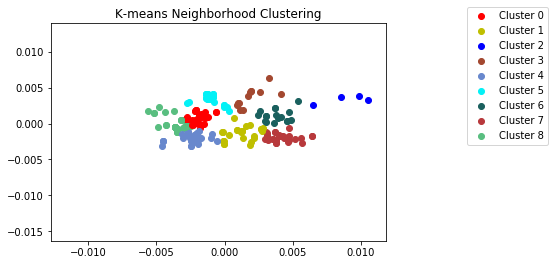

In [474]:
test_dfh = dfh[['latitude','longitude']].copy()
pca_test = PCA(n_components=2).fit(test_dfh)
pca_2d_test = pca_test.fit_transform(test_dfh)

kmeans = KMeans(n_clusters=9, random_state=111)
kmeans.fit(test_dfh)
plt.figure('K-means w/pca')
#plt.scatter(pca_2d_test[:, 0], pca_2d_test[:, 1], c=kmeans.labels_)

for i in range(0, pca_2d_test.shape[0]):
    if kmeans.labels_[i] == 0:
        c15 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='r')
    elif kmeans.labels_[i] == 1:
        c16 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='y')
    elif kmeans.labels_[i] == 2:
        c17 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='b')
    elif kmeans.labels_[i] == 3:
        c18 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#A34830')
    elif kmeans.labels_[i] == 4:
        c19 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#6888CD')
    elif kmeans.labels_[i] == 5:
        c20 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#03F1F6')
    elif kmeans.labels_[i] == 6:
        c21 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#1A605E')
    elif kmeans.labels_[i] == 7:
        c22 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#B8393C')
    elif kmeans.labels_[i] == 8:
        c23 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#59BE80')


plt.legend([c15,c16,c17,c18,c19,c20,c21,c22,c23],
          ['Cluster 0','Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5','Cluster 6',
          'Cluster 7', 'Cluster 8'],bbox_to_anchor=(1.5, 1.1))
plt.title('K-means Neighborhood Clustering')
#plt.axis('off')
plt.savefig('cluster_neighborhoods.pdf',bbox_inches='tight') #bbox_extra_artists=(legend,), bbox_inches='tight'
plt.show()

In [475]:
silhouette_score(test_dfh, kmeans.labels_)

0.43278901956256366

In [476]:
## KEEP IN CATEGORY
dfh['category'].replace('American (New)',0,inplace=True)
dfh['category'].replace('Italian',1, inplace=True)
dfh['category'].replace('Chinese',2, inplace=True)
dfh['category'].replace('Mexican',3, inplace=True)
dfh['category'].replace('Mediterranean',4, inplace=True)
dfh['category'].replace('Japanese',5, inplace=True)
dfh['category'].replace('Thai',6, inplace=True)
dfh['category'].replace('Indian',7, inplace=True)
dfh['category'].replace('Greek',8, inplace=True)
dfh['category'].replace('Latin American',9, inplace=True)
dfh['category'].replace('French',10, inplace=True)
dfh['category'].replace('Turkish',11, inplace=True)
dfh['category'].replace('Korean',12, inplace=True)
dfh['category'].replace('Caribbean',13, inplace=True)
dfh['category'].replace('Tex-Mex',14, inplace=True)
dfh['category'].replace('Barbeque',15, inplace=True)
dfh['category'].replace('Cafes',16,inplace=True)
dfh['category'].replace('Sandwiches',16, inplace=True)



In [479]:
##### PREVIOUS WORK STARTS HERE
#df = data[['latitude','longitude','city','category']]
#df = df.loc[df['city'] == 'Pittsburgh']
#df = df[['latitude','longitude','category']]

## TODO - RECENT ADDITIONS
df = dfh[['latitude','longitude','category','neighborhood']].copy() # ADDED
df[['latitude','longitude']] = (df[['latitude','longitude']].sub(df[['latitude','longitude']].mean())).divide(df[['latitude','longitude']].std())

## ADDED
dfh['category'].replace(0,'American (New)',inplace=True)
dfh['category'].replace(1,'Italian', inplace=True)
dfh['category'].replace(2,'Chinese', inplace=True)
dfh['category'].replace(3,'Mexican', inplace=True)
dfh['category'].replace(4,'Mediterranean', inplace=True)
dfh['category'].replace(5,'Japanese', inplace=True)
dfh['category'].replace(6,'Thai', inplace=True)
dfh['category'].replace(7,'Indian', inplace=True)
dfh['category'].replace(8,'Greek', inplace=True)
dfh['category'].replace(9,'Latin American', inplace=True)
dfh['category'].replace(10,'French', inplace=True)
dfh['category'].replace(11,'Turkish', inplace=True)
dfh['category'].replace(12,'Korean', inplace=True)
dfh['category'].replace(13,'Caribbean', inplace=True)
dfh['category'].replace(14,'Tex-Mex',inplace=True)
dfh['category'].replace(15,'Barbeque',inplace=True)
dfh['category'].replace(16,'Cafes',inplace=True)
dfh['category'].replace(17,'Sandwiches', inplace=True)


topDf = df.copy()
categoryList = df['category'].tolist()

def topCategories(categoryList):
    n = []
    for i in categoryList:
         n += [i.split(',')]   
    count={}
    for i in n:
        for j in i:
            if j not in count:
                count[j]=1
            else:
                count[j] = count[j] +1
    return OrderedDict(sorted(count.items(), key=lambda a:a[1], reverse=True))    

def convert(j):
    for i in top:
        if(i == j):
            return(top.index(i)+1)
        
top = list(topCategories(categoryList))[0:15]
topCatNames=[]
topCatNames = top
c =[]
for i in df['category']:
    row = i.split(',')
    c += [[convert(j) for j in row if j in top]]
topDf['category'] = c
topDf = topDf.reset_index(drop = True)
a = np.zeros(shape=(len(topDf['category']),15))
i=0
for j in c:
    for k in j:
        a[i,k-1]=1
    i+=1
top = pd.DataFrame.from_records(a)
top[['latitude','longitude']] = topDf[['latitude','longitude']]

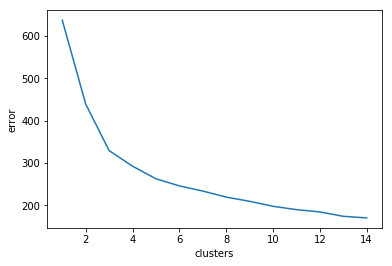

In [480]:
# evaluate the clusters
n = 15 # max clusters
error = np.zeros(n)
error[0] = 0;
for k in range(1,n):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(top)
    error[k] = kmeans.inertia_
plt.figure(1)
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('clusters')
plt.ylabel('error')
plt.savefig('kmeans_error.pdf', bbox_inches='tight')

In [481]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100) 
km = kmeans.fit_predict(top)
labels = kmeans.labels_

silhouette_score(top, labels, metric='euclidean')

0.2878013033964551

In [482]:
from sklearn import metrics
metrics.calinski_harabaz_score(top, labels) 

103.42695961397945

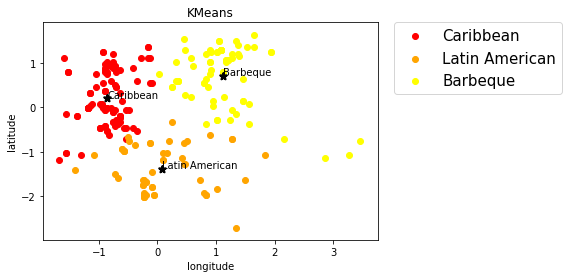

In [486]:
def createCentroids(centroids):
    y = 0  
    for i in centroids:
        plt.scatter(i[16],i[15],s=50,c='black',marker='*',linewidth=2)
        plt.annotate(labelsKm[y],xy=(i[16],i[15]))
        y+=1
    
def createScatter(clusters):
    colors = ['red','orange','yellow','green','blue','purple','cyan','magenta','black','#9BF591']
    x = 0
    for i in clusters:
        for j in i:
            plt.scatter(top['longitude'][j],top['latitude'][j], color=colors[x]) #org: lat, long
        x=x+1
        
def labels(cluster):
    count = {}
    for i in cluster[0]:
        for j in topDf['category'][i]:
            if j not in count:
                count[j] = 1
            else:
                count[j] +=1
    return OrderedDict(sorted(count.items(), key=lambda kv:kv[1], reverse=True))

def clusterLabel(lc,topCounts):
    maxx = 0
    for key,value in lc.items():
        temp = value/topCounts[key-1]
        if(temp>maxx):
            maxx = temp
            index = key-1
    return topCatNames[index]

topCounts = list(topCategories(categoryList).values())[0:15]
labelsKm = []
km0 = np.where(km==0)
lc = labels(km0)
labelsKm.append(clusterLabel(lc, topCounts))
km1 = np.where(km==1)
lc = labels(km1)
labelsKm.append(clusterLabel(lc, topCounts))

km2 = np.where(km==2)
lc = labels(km2)
labelsKm.append(clusterLabel(lc, topCounts))

# km3 = np.where(km==3)
# lc = labels(km3)
# labelsKm.append(clusterLabel(lc, topCounts))


clusters = [km0,km1,km2]
createScatter(clusters)
createCentroids(kmeans.cluster_centers_)

plt.title('KMeans')
plt.xlabel('longitude')
plt.ylabel('latitude')
legend = plt.legend([labelsKm[i] for i in range(len(labelsKm))],bbox_to_anchor=(1.05, 1),
                    loc=2, borderaxespad=0.,fontsize=15)

plt.savefig('kmeans_cuisines.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

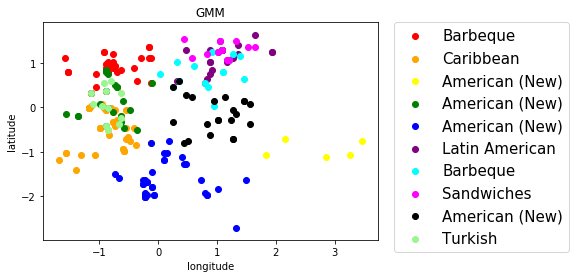

In [484]:
labelsGmm=[]
gmm = mixture.GMM(n_components=10,covariance_type='spherical')
gmm.fit(top)
gaussian = gmm.predict(top)
g0 = np.where(gaussian==0)
x= labels(g0)
labelsGmm.append(clusterLabel(x, topCounts))
g1 = np.where(gaussian==1)
x= labels(g1)
labelsGmm.append(clusterLabel(x, topCounts))
g2 = np.where(gaussian==2)
x= labels(g2)
labelsGmm.append(clusterLabel(x, topCounts))
g3 = np.where(gaussian==3)
x = labels(g3)
labelsGmm.append(clusterLabel(x, topCounts))


labelsGmm.append(clusterLabel(x, topCounts))
g4 = np.where(gaussian==4)
x = labels(g4)

labelsGmm.append(clusterLabel(x, topCounts))
g5 = np.where(gaussian==5)
x = labels(g5)
labelsGmm.append(clusterLabel(x, topCounts))

g6 = np.where(gaussian==6)
x = labels(g6)
labelsGmm.append(clusterLabel(x, topCounts))

g7 = np.where(gaussian==7)
x = labels(g7)
labelsGmm.append(clusterLabel(x, topCounts))

g8 = np.where(gaussian==8)
x = labels(g8)
labelsGmm.append(clusterLabel(x, topCounts))

g9 = np.where(gaussian==9)
x = labels(g9)
labelsGmm.append(clusterLabel(x, topCounts))




clustersGmm = [g0,g1,g2,g3,g4,g5,g6,g7,g8,g9] #,g4
createScatter(clustersGmm)
plt.title('GMM')
plt.xlabel('longitude') #latitude
plt.ylabel('latitude') #longitude
legend = plt.legend([labelsGmm[i] for i in range(len(labelsGmm))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
plt.show()

In [485]:
silhouette_score(top, gaussian, metric='euclidean')

0.21986359197458646

45


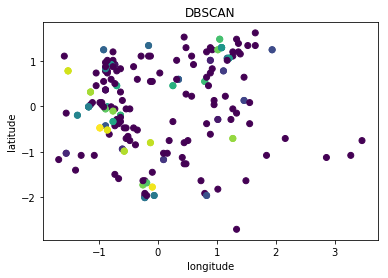

In [448]:
from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd


def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # radius of earth in km
    return c * r

X = df[['latitude','longitude']]
X[['latitude','longitude']] = (df[['latitude','longitude']].sub(df[['latitude','longitude']].mean())).divide(df[['latitude','longitude']].std())
distance_matrix = squareform(pdist(X, (lambda u,v: haversine(u,v))))

db = DBSCAN(eps=0.2, min_samples=2, metric='precomputed')
y_db = db.fit_predict(distance_matrix)
print(len(set(y_db)))
X['cluster'] = y_db

plt.scatter(X['longitude'], X['latitude'], c=X['cluster']) #latitude, long
plt.title('DBSCAN')
plt.xlabel('longitude') #latitude
plt.ylabel('latitude') #longitude
plt.show()